# <center> Individual assignement
### <center> Emir Boughzala 

In [1]:
import gymnasium as gym
import numpy as np
from text_flappy_bird_gym.envs.text_flappy_bird_env_simple import TextFlappyBirdEnvSimple
from text_flappy_bird_gym.envs.text_flappy_bird_env_screen import TextFlappyBirdEnvScreen
from text_flappy_bird_gym.envs.text_flappy_bird_logic import FlappyBirdLogic
import matplotlib.pyplot as plt

c:\Users\Emir\.conda\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Agent 0 : Random policy 

In [2]:
# Defining an agent that choses a random action every state 
class RandomAgent:
    def __init__(self):
        pass

    def act(self, state):
        """
            The policy of this agent is just choosing a random action : either he does nothing (0) or he flaps (1)
        """
        return np.random.randint(0,2)

In [3]:
#Defining the space parameters
height = 15
width = 20
pipe_gap = 4

x_dist_max = width-1
y_dist_max = height-1-int(pipe_gap//2)-1
y_dist_min = -y_dist_max

#Initialization
env = gym.make('TextFlappyBird-v0', height = height, width = width, pipe_gap = pipe_gap)
obs = env.reset()
agent = RandomAgent()

#Evaluation of the agent
while True:
    action = agent.act(obs) 
    obs, reward, done, _, info = env.step(action)
    if done:
        break


print("Observation : " , obs)
print("Reward : " , reward)
print("Done : " , done)
print("Info : " , info)

env.close()

Observation :  (9, 12)
Reward :  1
Done :  True
Info :  {'score': 0, 'player': [6, 15], 'distance': 15.0}


## Agent 1 : Q-learning $\epsilon$-greedy agent

In [4]:
class QLearningAgent:
    def __init__(self, learning_rate, discount_factor, epsilon, epsilon_decay_rate, n_actions):
        """
            Defining the paremeters for the Q-learning agent 
        """
        self.lr = learning_rate
        self.df = discount_factor # discount factor for future rewards
        self.epsilon = epsilon # exploration rate for choosing actions
        self.epsilon_decay_rate = epsilon_decay_rate # decay rate for exploration rate
        self.n_actions = n_actions # number of possible actions (flap or do nothing)
        self.Q = np.zeros((x_dist_max+1,y_dist_max-y_dist_min, n_actions)) # initialize Q-values with zeros

    def act(self, observation):
        if np.random.rand() < self.epsilon: # with probability epsilon, choose a random action for exploration
            action = np.random.randint(0, self.n_actions)
        else: # with probability 1-epsilon, choose the action with the highest Q-value for exploitation
            action = np.argmax(self.Q[observation])
        return action

    def update_Q(self, observation, action, reward, next_observation,done):
        max_Q_next = np.max(self.Q[next_observation])
        # Q-learning update rule
        self.Q[observation][action] += self.lr * ( (reward + self.df * max_Q_next) - self.Q[observation][action]) 
        # Add a penalty for losing the game
        if done :
            self.Q[observation][action]+= -1000
    def decay_epsilon(self):
        self.epsilon *= self.epsilon_decay_rate

First, I defined the Q-learning agent parameters as recommended [in this article](https://towardsdatascience.com/reinforcement-learning-in-python-with-flappy-bird-37eb01a4e786).

In the following section, you'll find a hyperparameter tuning to find the optimal parameters, and those parameters are the ones kept in my work.

In [85]:
learning_rate = 1
discount_factor = 0.3684
epsilon = 0.36842
epsilon_decay_rate = 0.9473684

n_actions = 2  # flap or do nothing


agent = QLearningAgent(learning_rate, discount_factor, epsilon, epsilon_decay_rate, n_actions)

In [86]:
#training phase
num_episodes = 2000
score = []
for i in range(num_episodes):
    observation, info = env.reset()
    done = False
    while not done:
        action = agent.act(observation)
        obs, reward, done, _, info = env.step(action)
        done = (info["score"] > 500) or done
        next_observation = obs
        agent.update_Q(observation, action, reward, next_observation, done)
        observation = next_observation
        agent.decay_epsilon()
    score.append(info["score"])
window_size=50
window_average = [round(np.sum(score[i:i+window_size]) / window_size, 2)for i in range(len(score) - window_size + 1)]

In [87]:
# evaluation
obs,info = env.reset()
while True:
    observation = obs
    action = agent.act(observation)  
    obs, reward, done, _, info = env.step(action)
    done = (info["score"] > 500) or done
    if done:
        break
print("obs : " , obs)
print("reward : " , reward)
print("done : " , done)
print("info : " , info)

env.close()

obs :  (9, -9)
reward :  1
done :  True
info :  {'score': 501, 'player': [6, 2], 'distance': 12.727922061357855}


### State value function

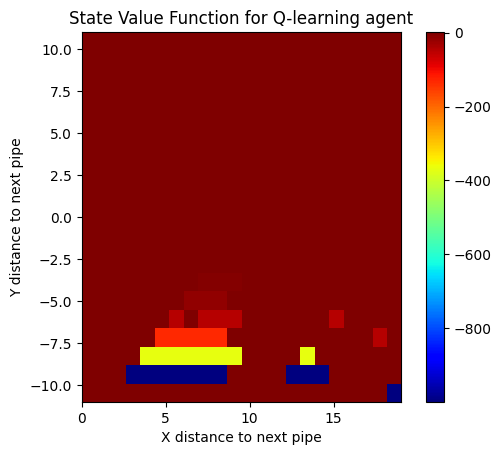

In [92]:
V = np.max(agent.Q, axis = 2)
plt.imshow(V, origin = "lower", cmap='jet', extent=[0, x_dist_max, y_dist_min, y_dist_max])
plt.colorbar()# Plot the state value function
plt.title('State Value Function for Q-learning agent')
plt.xlabel('X distance to next pipe')
plt.ylabel('Y distance to next pipe')
plt.show()

### Learning curve

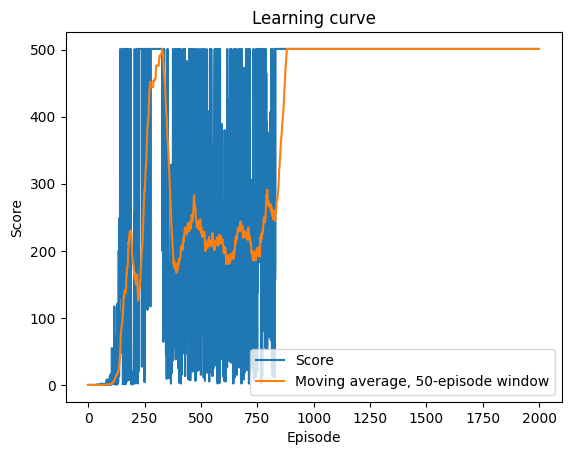

In [88]:
plt.plot(score,label = 'Score')
plt.plot([0]*window_size+window_average, label=f"Moving average, {window_size}-episode window")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("Learning curve")
plt.legend()
plt.show()

## Agent 2 : SARSA($\lambda$) agent

In [10]:
class SARSAAgent:
    def __init__(self, alpha, epsilon, gamma, n_actions):
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.n_actions = n_actions
        self.Q = np.zeros((x_dist_max+1,y_dist_max-y_dist_min, n_actions)) # initialize Q-values with zeros

    def act(self, observation):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, self.n_actions)
        else:
            action = np.argmax(self.Q[observation])
        return action

    def update_Q(self, observation, action, reward, next_observation, next_action, done):
        td_error = reward + self.gamma * self.Q[next_observation][next_action] - self.Q[observation][action]
        self.Q[observation][action] += self.alpha * td_error
        if done :
            self.Q[observation][action]+= -1000

Same as before, these parameters were fixed after the parameter tuning.

In [94]:
height = 15
width = 20
pipe_gap = 4

#Initialization
env = gym.make('TextFlappyBird-v0', height = height, width = width, pipe_gap = pipe_gap)

gamma = 1
alpha = 0.579
epsilon = 0

n_actions = 2  # flap or do nothing


agent = SARSAAgent(alpha, epsilon, gamma, n_actions)


In [95]:
#training phase
num_episodes = 2000
score = []
for i in range(num_episodes):
    observation, info = env.reset()
    action = agent.act(observation)
    done = False
    while not done:
        next_observation, reward, done, _, info = env.step(action)
        done = info["score"] > 500 or done
        next_action = agent.act(next_observation)
        agent.update_Q(observation, action, reward, next_observation, next_action,done)
        observation = next_observation
        action = next_action
    score.append(info["score"])

window_size=50
window_average = [round(np.sum(score[i:i+window_size]) / window_size, 2)for i in range(len(score) - window_size + 1)]

In [97]:
# evaluation
obs,info = env.reset()
while True:
    observation = obs
    action = agent.act(observation)  
    obs, reward, done, _, info = env.step(action)
    done = (info["score"] > 500) or done
    if done:
        break
print("obs : " , obs)
print("reward : " , reward)
print("done : " , done)
print("info : " , info)

env.close()

obs :  (9, -6)
reward :  1
done :  True
info :  {'score': 501, 'player': [6, 1], 'distance': 10.816653826391969}


### State value function

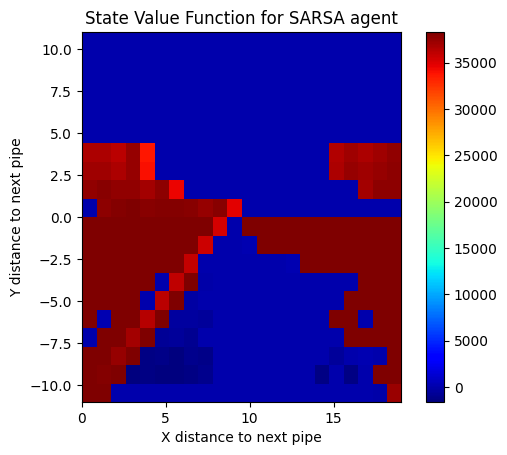

In [100]:
V = np.max(agent.Q, axis = 2)
plt.imshow(V, origin = "lower", cmap='jet', extent=[0, x_dist_max, y_dist_min, y_dist_max])
plt.colorbar()# Plot the state value function
plt.title('State Value Function for SARSA agent')
plt.xlabel('X distance to next pipe')
plt.ylabel('Y distance to next pipe')
plt.show()

###  Learning curve

In [ ]:
plt.plot(score,label = 'Score')
plt.plot([0]*window_size+window_average, label=f"Moving average, {window_size}-episode window")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("Learning curve")
plt.legend()
plt.show()

## Hyperparameters tuning

For this hyperparameter tuning section, I will use the average realized score over all episodes for as a metric of performance.
I will also fix the realized episodes to $1000$. 

### First agent

As there are 4 parameters in this agent, I will assume that $\epsilon$ and its decay are independent. 

At first, I will fix the values of $\epsilon$ and the $\epsilon$-decay rate and perform a grid search on the discount factor and learning rate.

I will use this first gridsearch to fix the values of the discount factor and learning rate then perform a gridsearch on $\epsilon$ and the $\epsilon$-decay rate.

In [ ]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', height = height, width = width, pipe_gap = pipe_gap)
n_actions = 2 

#### GridSearch on DF and LR

In [ ]:
"""
    This block of code takes ~40min to complete on my computer.
"""

learning_rates = np.linspace(0,1,20)
discount_factors = np.linspace(0,1,20)
epsilon=0.01
epsilon_decay_rate = 1

average_score = np.zeros( (len(learning_rates),len(discount_factors)  ) )

for lr,learning_rate in enumerate(learning_rates) : 
    for df, discount_factor in enumerate(discount_factors) :
        agent = QLearningAgent(learning_rate, discount_factor, epsilon, epsilon_decay_rate, n_actions)
        num_episodes = 1000
        score = []
        for i in range(num_episodes):
            observation, info = env.reset()
            done = False
            while not done:
                action = agent.act(observation)
                obs, reward, done, _, info = env.step(action)
                done = (info["score"] > 500) or done
                next_observation = obs
                agent.update_Q(observation, action, reward, next_observation, done)
                observation = next_observation
                agent.decay_epsilon()
            score.append(info["score"])
        average_score[lr,df] = np.mean(score)
env.close()


plt.imshow(average_score.T, origin='lower', cmap='jet', extent=[discount_factors[0], discount_factors[-1], learning_rates[0], learning_rates[-1]])
plt.colorbar()# Plot the state value function
plt.title('GridSearch')
plt.xlabel('Discount factor')
plt.ylabel('Learning Rate')
plt.show()

In [ ]:
plt.imshow(average_score.T, origin='lower', cmap='jet', extent=[discount_factors[0], discount_factors[-1], learning_rates[0], learning_rates[-1]])
plt.colorbar()# Plot the state value function
plt.title('GridSearch')
plt.xlabel('Discount factor')
plt.ylabel('Learning Rate')
plt.title(f'Q-learning agent\'s GridSearch for $\epsilon$ = {epsilon} and $\epsilon$-decay = {epsilon_decay_rate}')

plt.show()

In [ ]:
df_idx, lr_idx  =np.unravel_index(np.argmax(average_score), np.array(average_score).shape)

best_learning_rate = learning_rates[lr_idx] #1
best_discount_factor = discount_factors[df_idx]

print(f"Best values : LR = {best_learning_rate:.3f}, DF = {best_discount_factor:.3f}")


#### GridSearch on $\epsilon$ and $\epsilon$-decay


In [ ]:
"""
    This block of code takes ~40min to complete on my computer.
"""

learning_rate = learning_rates[lr_idx] #1
discount_factor = discount_factors[df_idx] #0.3684 


epsilons = np.linspace(0,1,20)
epsilon_decay_rates = np.linspace(0,1,20)

average_score = np.zeros( ( len(epsilons),len(epsilon_decay_rates) ) )


for e,epsilon in enumerate(epsilons) : 
    for ed, epsilon_decay_rate in enumerate(epsilon_decay_rates) : 
        agent = QLearningAgent(learning_rate, discount_factor, epsilon, epsilon_decay_rate, n_actions)
        num_episodes = 1000
        score = []
        for i in range(num_episodes):
            observation, info = env.reset()
            done = False
            while not done:
                action = agent.act(observation)
                obs, reward, done, _, info = env.step(action)
                done = (info["score"] > 500) or done
                next_observation = obs
                agent.update_Q(observation, action, reward, next_observation, done)
                observation = next_observation
                agent.decay_epsilon()
            score.append(info["score"])
        average_score[e,ed] = np.mean(score)
                
env.close()

In [ ]:
plt.imshow(average_score.T, origin='lower', cmap='jet', extent=[epsilons[0], epsilons[-1], epsilon_decay_rates[0], epsilon_decay_rates[-1]])
plt.colorbar()# Plot the state value function
plt.title(f'Q-learning agent\'s GridSearch for LR = {learning_rate} and DF = {discount_factor}')
plt.xlabel('$\epsilon$')
plt.ylabel('$\epsilon$-decay rate')
plt.show()

In [ ]:
ed_idx, eps_idx  =np.unravel_index(np.argmax(average_score), np.array(average_score).shape)

best_epsilon = epsilons[eps_idx] 
best_epsilon_decay = epsilon_decay_rates[ed_idx]

print(f"Best values : $\epsilon$ = {best_epsilon:.3f}, $\epsilon$-decay = {best_epsilon_decay:.3f}")


In [ ]:
"""
    Optimal values found :
"""

learning_rate = 1
discount_factor = 0.3684
epsilon = 0.36842
epsilon_decay_rate = 0.9473684

### Second agent

In [ ]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', height = height, width = width, pipe_gap = pipe_gap)

n_actions = 2 
y_dist_max = height-1-int(pipe_gap//2)-1
n_observations = 2*y_dist_max+1


In [ ]:
"""
    This block of code took 140 minutes to complete on my machine.
"""

gammas = np.linspace(0,1,20)
alphas = np.linspace(0,1,20)
epsilons = np.linspace(0,1,20)

average_score = np.zeros( (len(gammas),len(alphas),len(epsilons)  ) )

for gamma_index,gamma in enumerate(gammas) : 
    for alpha_index, alpha in enumerate(alphas) :
        iteration_number = gamma_index * len(alphas) + alpha_index 
        print(f"Iteration {iteration_number}: gamma={round(gamma,2)}, alpha={round(alpha,2)} - {round(100*iteration_number/(20*20),2)}%")
        for eps_index,epsilon in enumerate(epsilons) : 
            agent = SARSAAgent(alpha, epsilon, gamma, n_actions)
            num_episodes = 1000
            score = []
            for i in range(num_episodes):
                observation, info = env.reset()
                action = agent.act(observation)
                done = False
                while not done:
                    next_observation, reward, done, _, info = env.step(action)
                    done = info["score"] > 500 or done
                    next_action = agent.act(next_observation)
                    agent.update_Q(observation, action, reward, next_observation, next_action,done)
                    observation = next_observation
                    action = next_action
                score.append(info["score"])
            average_score[gamma_index,alpha_index,eps_index] =  np.mean(score)#[int(len(score)*0.3):]
env.close()

In [ ]:
max_indices = np.unravel_index(np.argmax(average_score), average_score.shape)
gamma_index, alpha_index, epsilon_index = max_indices
# I take the maximum value of average_score then plot the correspoinding 2-D graph fixing the value of epsilon
# Plot corresponding 2D graph
plt.imshow(average_score[:,:,epsilon_index].T, origin='lower', cmap='jet', extent=[gammas[0], gammas[-1], alphas[0], alphas[-1]])
plt.colorbar()
plt.title(f'SARSA - GridSearch for $\epsilon$ = {epsilons[epsilon_index]} (best value)')
plt.xlabel('Gamma')
plt.ylabel('Alpha') 
plt.show()

In [ ]:
best_gamma = gammas[gamma_index] 
best_alpha = alphas[alpha_index]
best_epsilon = epsilons[epsilon_index]
print(f"Best values : gamma = {best_gamma:.3f}, alpha = {best_alpha:.3f}, epsilon = {best_epsilon:.3f}")
